# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [135]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display


### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [136]:
import numpy as npp
import autograd
import autograd.numpy as np
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f



In [59]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

def f(x,y):
    return(np.array([x**2,y**2]))

h=J(f)
x,y=1.0,2.0
print(h(x,y))
print(type(h(x,y)))

[[2. 0.]
 [0. 4.]]
<class 'numpy.ndarray'>


Exemples d'usage :

In [138]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [139]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

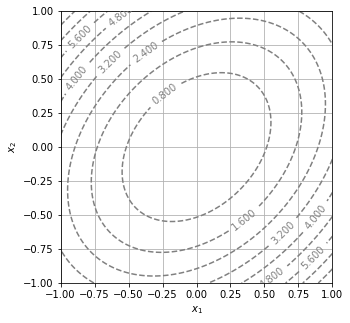

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

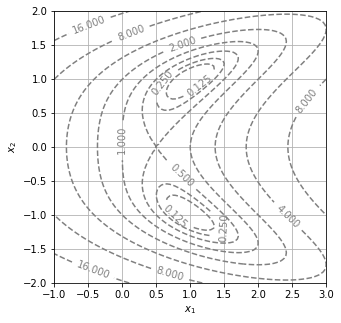

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

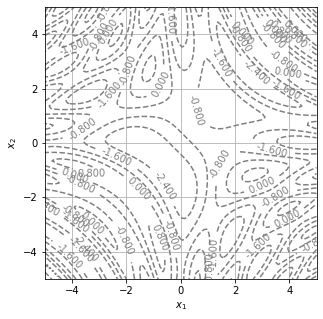

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [44]:
#Les cases n'étaient pas réliées, on a du import les librairies à chaque nouvelle case


#étant donné que le tracé sera un tracé des courbes de niveau, 
#qui est précis à hauteur de l'épaisseur du trait de tracé, on prend :
eps = 0.001
N = 100

import autograd
import autograd.numpy as np



[[1. 0.]
 [0. 1.]]
<class 'numpy.ndarray'>
[[1. 0.]
 [0. 1.]]
1.0


**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [140]:
import autograd
import autograd.numpy as np
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

def Newton(F, x0, y0, eps=0.01, N=100):
    h = J(F)
    for i in range(N):
        x = x0 - np.dot(np.linalg.inv(h(x0,y0)), F(x0,y0))[0] #On ignore les potentiels déterminants nuls
        y = y0 - np.dot(np.linalg.inv(h(x0,y0)), F(x0,y0))[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.array([3.0 * x * x - 2.0 * x * y + 3.0 * y * y,y-x])

print(Newton(f1,0.8,0.8,0.01,100))

(0.00625, 0.00625)


**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [141]:
import autograd
import autograd.numpy as np
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.array([3.0 * x * x - 2.0 * x * y + 3.0 * y * y,y-x])

def F1(x,y):
    return f1(x,y) - np.array([0.8, 0])

Newton(F1, 0.8, 0.8,0.01,100)

(0.447250250297228, 0.447250250297228)

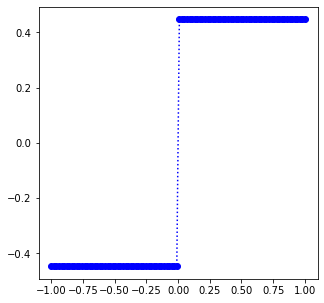

In [142]:
import autograd
import autograd.numpy as np
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

N = 100
X = np.linspace(-1,1,N)

vecNewton = np.vectorize(Newton)
Y = vecNewton(F1, X, X,0.001,N)
plt.plot(X,Y[0],'b:o')
plt.show()

In [62]:
import autograd
import autograd.numpy as np
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

def g1(x,y):
    return np.array([f1(x,y)[0]-0.8,x**2-y**3]) #On ne change que le deuxième argument de la fonction

(0.36218775699130284, 0.5081082104487147)

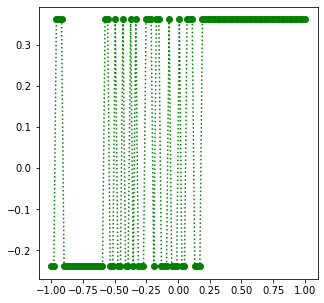

In [143]:
n = 100
X = np.linspace(-1,1,n)

Y = []
for i in range (0,n) :
    Y.append(Newton(g1, X[i], X[i])[0])
plt.plot(X,Y,'g:o')
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [65]:
import autograd
import autograd.numpy as np
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


def level_curve0(f, x0, y0, c, delta=0.1, N=1000, eps=eps) :
    R = np.array([0.0,1.0,-1.0,0.0])
    R.resize((2,2)) #Matrice de rotation de -pi/2
    grad_f = grad(f)
    T = np.zeros((2,N)) #Il s'agit de l'ensemble des points de la courbe de niveau
    T[0,0], T[1,0] = x0, y0
    x1, y1 = x0, y0
    for i in range (1,N):
        v_droite = np.dot(R,grad_f(x1,y1).T)         #vecteur orthogonal à droite du gradient de f en (x0,y0)
        u = v_droite/(v_droite[0]**2+v_droite[1]**2)**(0.5)      #u est le normalisé de v_droite
        def f_R2(x,y):
            return np.array([f(x,y) - c, np.dot(np.array([x-x1, y-y1]),u.T) - delta]) #On s'assure d'avoir f(x,y)=c et que le point résultant est bien à distance delta du point initial
        x1, y1 = Newton(f_R2, x1, y1, eps, 100)          
        T[0,i] , T[1,i] = x1, y1
    return T

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [129]:
import autograd
import autograd.numpy as np
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

def level_curve(f, x0, y0, c, delta=0.1, N=1000, eps=eps) :
    R = np.array([0.0,1.0,-1.0,0.0])
    R.resize((2,2)) #Matrice de rotation de -pi/2
    grad_f = grad(f)
    X = [x0]
    Y = [y0]
    x1, y1 = x0, y0  
    for i in range (1,N):
        v_droite = np.dot(R,grad_f(x1,y1).T)         #Vecteur orthogonal à droite du gradient de f en (x0,y0)
        u = v_droite/(v_droite[0]**2+v_droite[1]**2)**(0.5)      #u est le normalisé de v_droite
        def f_R2(x,y):
            return np.array([f(x,y) - c, np.dot(np.array([x-x1, y-y1]),u.T) - delta]) #On s'assure d'avoir f(x,y)=c et que le point résultant est bien à distance delta du point initial
        x1, y1 = Newton(f_R2, x1, y1, eps, 100)          
        X.append(x1)
        Y.append(y1)
        if ((x1-x0)**2+(y1-y0)**2)**0.5 < delta - eps: #On fait des pas de l'ordre de delta, après un tour, on se trouve à moins de delta - eps du point de départ
            return np.array([X,Y])
    return np.array([X,Y])



**Question** Valider graphiquement le résultat au moyen des exemples de référence.

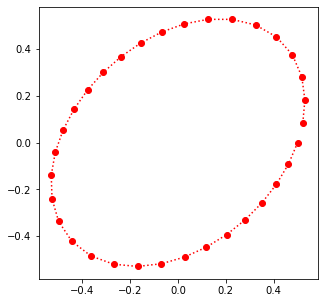

In [130]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y

def plt_level_curve0(f, x0, y0, c, delta=0.1, N=1000, eps=eps):
    X, Y = level_curve0(f, x0, y0, c, delta, N, eps)
    plt.plot(X,Y, 'r:o')
    plt.show()

plt_level_curve0(f1,0.5,0.0,0.75,0.1,100,0.001)

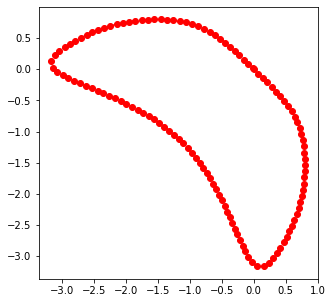

In [131]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

plt_level_curve0(f3,0.0,0.0,-2.0,0.1,1000,0.001)

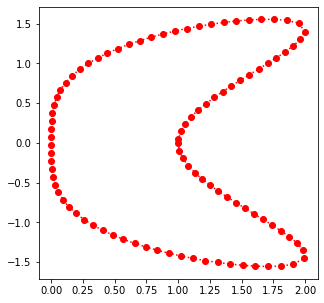

In [132]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2


plt_level_curve0(f2,1.,0.0,1.0,0.1,100,0.001)

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

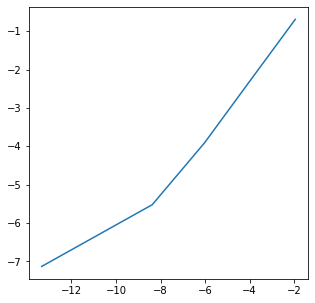

In [79]:
import math
import numpy as np
import matplotlib.pyplot as plt

def area_squares(f,c,h):
    x=0
    y=0
    i,j=0,0
    while f(x,0)<=c or f(-x,0)<=c:
        x+=h
        i+=1
    while f(0,y)<=c or f(0,-y)<=c:
        y+=h
        j+=1
    carre = []
    for a in range(i):
        for b in range(j):
            carre.append([(a+0.5)*h,(b+0.5)*h]) #Afin de plonger K dans un carré, on se restreint ici à des formes simples telles que le cercle unité
            carre.append([-(a+0.5)*h,(b+0.5)*h])
            carre.append([(a+0.5)*h,-(b+0.5)*h])
            carre.append([-(a+0.5)*h,-(b+0.5)*h])
    res=0
    for element in carre:
        if f(element[0],element[1])<=c:
            res+=h*h
    return(res)

def f(x1,x2):
    return(math.sqrt(x1**2 + x2**2))

Ah = []
T = []
h=0.5
for i in range(5):
    Ah.append(math.log(abs(area_squares(f,1,h)-np.pi)))
    T.append(math.log(h))
    h = h/5


plt.plot(Ah,T)
plt.show()


In [ ]:
#On a une pente environ égale à -1 donc une convergence quasi linéaire

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

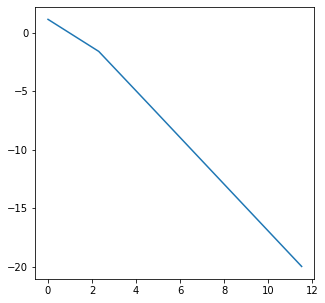

In [133]:
import math
import matplotlib.pyplot as plt
           
def aire_triangle(a,b,c):
    u = np.array([b[0] - a[0], b[1] - a[1]])
    v = np.array([c[0] - a[0], c[1] - a[1]])
    return vect(u,v)/2 #En passant par le produit vectoriel on autorise des aires négatives, ce qui est utile pour la suite

def vect(x,y):
    return(x[0]*y[1]-x[1]*y[0])

def aire(X,y):
    s=0
    for i in range(len(X)-1):
        s+=aire_triangle(y,X[i],X[i+1])
    s+=aire_triangle(y,X[len(X)-1],X[0])
    return(abs(s))

pi=math.pi
y=[0,0]
X=[math.log(10**i) for i in range(6)]
Y=[]
for i in range(6):
    j=10**i
    T = [[math.cos(2*i*pi/j),math.sin(2*i*pi/j)] for i in range(1,j+1)] #On paramètre le cercle unité dans le sens trigonométrique
    Y.append(math.log(abs(aire(T,y) - math.pi)))

plt.plot(X,Y)
plt.show()


In [ ]:
# On a une pente de l'odre de -2 donc une vitesse de convergence quadratique en fonction du nombre de points choisis 

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [95]:
import math

def aire_triangle(a,b,c):
    u = np.array([b[0] - a[0], b[1] - a[1]])
    v = np.array([c[0] - a[0], c[1] - a[1]])
    return vect(u,v)/2

def vect(x,y):
    return(x[0]*y[1]-x[1]*y[0])

def aire(X,y):
    s=0
    for i in range(len(X)-1):
        s+=aire_triangle(y,X[i],X[i+1])
    s+=aire_triangle(y,X[len(X)-1],X[0])
    return(abs(s))

pi = math.pi
y = (0,0)

epsilon = 10**(-2) #Précision de l'encadrement

j=1000
X1 = [[math.cos(2*i*pi/j),math.sin(2*i*pi/j)] for i in range(1,j+1)]
X2 = [[math.cos(2*i*pi/(j+1)),math.sin(2*i*pi/(j+1))] for i in range(1,j+2)]
while(int(aire(X2,y)/(10*epsilon)) - int(aire(X1,y)/(10*epsilon)))!=0: #Cela caractérise la stabilité de la valeur renvoyée par la méthode des triangles à la précision epsilon. On ne sort de la boucle que si la méthode a convergé à epsilon près
    j=j*10
    X1 = [[math.cos(2*i*pi/j),math.sin(2*i*pi/j)] for i in range(1,j+1)]
    X2 = [[math.cos(2*i*pi/(j+1)),math.sin(2*i*pi/(j+1))] for i in range(1,j+2)]
    
print(epsilon*int(aire(X1,y)/epsilon),epsilon*(int(aire(X1,y)/epsilon)+1))

3.14 3.15


**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [96]:
import math

def aire_triangle(a,b,c):
    u = np.array([b[0] - a[0], b[1] - a[1]])
    v = np.array([c[0] - a[0], c[1] - a[1]])
    return vect(u,v)/2

def vect(x,y):
    return(x[0]*y[1]-x[1]*y[0])

def aire(X,y):
    s=0
    for i in range(len(X)-1):
        s+=aire_triangle(y,X[i],X[i+1])
    s+=aire_triangle(y,X[len(X)-1],X[0])
    return(abs(s))

j = 10**4
X = [[math.cos(2*i*pi/j),math.sin(2*i*pi/j)] for i in range(1,j+1)]
y = [-1.5, 1.5] #On se place hors du cercle unité
    
print(aire(X, y))

3.1415924468812904


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [98]:
import math

def aire_triangle(a,b,c):
    u = np.array([b[0] - a[0], b[1] - a[1]])
    v = np.array([c[0] - a[0], c[1] - a[1]])
    return vect(u,v)/2

def vect(x,y):
    return(x[0]*y[1]-x[1]*y[0])

def aire(X,y):
    s=0
    for i in range(len(X)-1):
        s+=aire_triangle(y,X[i],X[i+1])
    s+=aire_triangle(y,X[len(X)-1],X[0])
    return(abs(s))

j = 10**4
X = [[math.cos(2*i*pi/j),math.sin(2*i*pi/j)] for i in range(1,j+1)] + [[3 + math.cos(2*i*pi/j),3 + math.sin(2*i*pi/j)] for i in range(1,j+1)] + [[-3 + math.cos(2*i*pi/j),-3 + math.sin(2*i*pi/j)] for i in range(1,j+1)]
y = [1.5, 1.5]

print(aire(X, y)) #On trouve bien 3*pi

9.424777340643743


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [120]:
import math

def aire_triangle(a,b,c):
    u = np.array([b[0] - a[0], b[1] - a[1]])
    v = np.array([c[0] - a[0], c[1] - a[1]])
    return vect(u,v)/2

def vect(x,y):
    return(x[0]*y[1]-x[1]*y[0])

def aire(X,y):
    s=0
    for i in range(len(X)-1):
        s+=aire_triangle(y,X[i],X[i+1])
    s+=aire_triangle(y,X[len(X)-1],X[0])
    return(abs(s))

def area_triangles(x,y):
    X = [[x[i], y[i]] for i in range(len(x))]
    point = [x[0], y[0]]
    return(aire(X, point))

j = 10**4
X = [math.cos(2*i*pi/j) for i in range(j)]
Y = [math.sin(2*i*pi/j) for i in range(j)]

print(area_triangles(X,Y))

3.1415924468812917


In [134]:
import autograd
import autograd.numpy as np
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

def level_curve(f, x0, y0, c, delta=0.1, N=1000, eps=eps) :
    R = np.array([0.0,1.0,-1.0,0.0])
    R.resize((2,2)) #Matrice de rotation de -pi/2
    grad_f = grad(f)
    X = [x0]
    Y = [y0]
    x1, y1 = x0, y0  
    for i in range (1,N):
        v_droite = np.dot(R,grad_f(x1,y1).T)         #Vecteur orthogonal à droite du gradient de f en (x0,y0)
        u = v_droite/(v_droite[0]**2+v_droite[1]**2)**(0.5)      #u est le normalisé de v_droite
        def f_R2(x,y):
            return np.array([f(x,y) - c, np.dot(np.array([x-x1, y-y1]),u.T) - delta]) #On s'assure d'avoir f(x,y)=c et que le point résultant est bien à distance delta du point initial
        x1, y1 = Newton(f_R2, x1, y1, eps, 100)          
        X.append(x1)
        Y.append(y1)
        if ((x1-x0)**2+(y1-y0)**2)**0.5 < delta - eps: #On fait des pas de l'ordre de delta, après un tour, on se trouve à moins de delta - eps du point de départ
            return np.array([X,Y])
    return np.array([X,Y])

def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y

def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

print(area_triangles(level_curve(f1,0.5,0.0,0.75,0.1,100,0.001)[0], level_curve(f1,0.5,0.0,0.75,0.1,100,0.001)[1]), area_squares(f1,0.75,0.01))
print(area_triangles(level_curve(f3,0.0,0.0,-2.0,0.1,1000,0.001)[0],level_curve(f3,0.0,0.0,-2.0,0.1,1000,0.001)[1]), area_squares(f3,-2.0,0.01))


0.8277557485469819 0.8059999999999276
7.052770705143194 9.34509999999156
